![image](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)
# Use watsonx and SingleStoreDB with Langchain to respond to natural language questions using RAG approach

This notebook contains the steps and code to demonstrate support of Retrieval Augumented Generation in watsonx.ai with SingleStoreDB as the knowledge base. It introduces commands for data retrieval, knowledge base building & querying, and model testing.

Some familiarity with Python is helpful. This notebook uses Python 3.10.

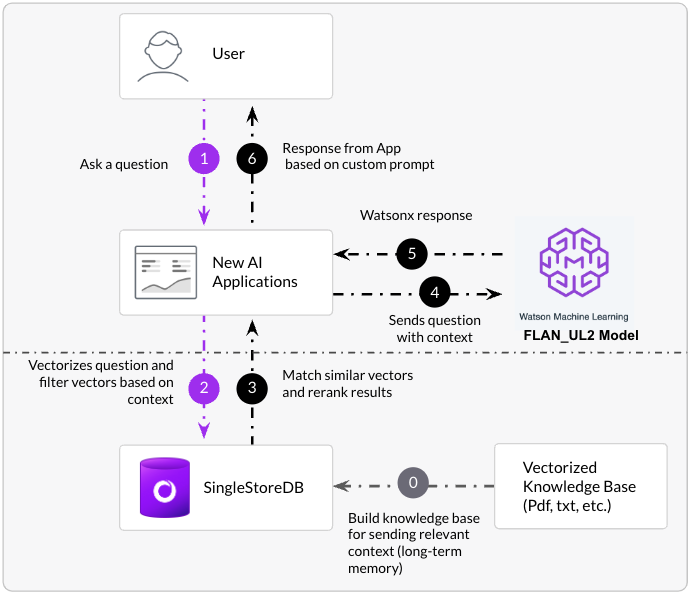

<a id="setup"></a>
##  Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-service-instance.html?context=analytics" target="_blank" rel="noopener no referrer">here</a>).


### Install and import dependencies

In [10]:
import os, getpass
import pandas as pd
from typing import Optional, Dict, Any, Iterable, List
from sqlalchemy import *
from dotenv import load_dotenv
#from sqlalchemy import create_engine
from langchain.vectorstores import SingleStoreDB
import json
from langchain.text_splitter import RecursiveCharacterTextSplitter
from ibm_watson_machine_learning.foundation_models.utils.enums import ModelTypes
from ibm_watson_machine_learning.foundation_models import Model
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams
from ibm_watson_machine_learning.foundation_models.utils.enums import ModelTypes, DecodingMethods

try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    raise ImportError("Could not import sentence_transformers: Please install sentence-transformers package.")

### SingleStoreDB connection

Those cells defines the credentials required to work with SingleStoreDB. 

Make sure that you have a database created in SingleStoreDB called **watsonx_ibm**

In [11]:
#config watsonx.ai environment
load_dotenv()
ibm_apikey = os.getenv("IBM_APIKEY", None)
ssdb_password = os.getenv("SSDB_PASSWORD", None)
ssdb_host = os.getenv("SSDB_HOST", None)
watson_project_id = os.getenv("PROJECT_ID", None)

if ibm_apikey is None or ssdb_password is None or ssdb_host is None or watson_project_id is None:
    print("ERROR: DO NOT PROGRESS UNTILL YOU FIX THIS: Ensure you copied the .env file that you created earlier into the same directory as this notebook")

In [12]:
connection_user = 'admin'
connection_password = ssdb_password
connection_port = '3306'
connection_host = ssdb_host
database_name = 'watsonx_ibm_lab1'

In [13]:
# Connection string to use Langchain with SingleStoreDB
os.environ["SINGLESTOREDB_URL"] = f"{connection_user}:{connection_password}@{connection_host}:{connection_port}/{database_name}"

# With database connection URL
connection_url = f"singlestoredb://{connection_user}:{connection_password}@{connection_host}:{connection_port}/{database_name}"
engine = create_engine(connection_url)

### watsonx API connection
This cell defines the credentials required to work with watsonx API for Foundation
Model inferencing.


In [17]:
wml_credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": ibm_apikey
}


### Defining the project id
The API requires project id that provides the context for the call. We will obtain the id from the project in which this notebook runs. Otherwise, please provide the project id.

**Hint**: You can find the `project_id` as follows. Open the prompt lab in watsonx.ai. At the very top of the UI, there will be `Projects / <project name> /`. Click on the `<project name>` link. Then get the `project_id` from Project's Manage tab (Project -> Manage -> General -> Details).


In [18]:
project_id = watson_project_id

### Defining the model parameters
We need to provide a set of model parameters that will influence the result:

In [19]:
generate_parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.GREEDY,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.MAX_NEW_TOKENS: 50
}

### List available models

In [20]:
print([e.value for e in ModelTypes])

['google/flan-t5-xxl', 'google/flan-ul2', 'bigscience/mt0-xxl', 'eleutherai/gpt-neox-20b', 'ibm/mpt-7b-instruct2', 'bigcode/starcoder', 'meta-llama/llama-2-70b-chat', 'meta-llama/llama-2-13b-chat', 'ibm/granite-13b-instruct-v1', 'ibm/granite-13b-chat-v1']


Pick one LLM model (e.g. FLAN_UL2, STARCODER)

In [51]:
llm_model = 'google/flan-ul2'

Initialize the `Model` class.

In [52]:
model = Model(
    model_id=llm_model,
    params=generate_parameters,
    credentials=wml_credentials,
    project_id=project_id
)

In [53]:
from ibm_watson_machine_learning.foundation_models.extensions.langchain import WatsonxLLM
llm_model = WatsonxLLM(model=model)

### Set connection to the public repository storage

In [25]:
import boto3
from io import StringIO
import botocore

## Build up knowledge base

The current state-of-the-art in RAG is to create dense vector representations of the knowledge base in order to calculate the semantic similarity to a given user query.

We can generate dense vector representations using embedding models. In this notebook, we use [SentenceTransformers](https://www.google.com/search?client=safari&rls=en&q=sentencetransformers&ie=UTF-8&oe=UTF-8) [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) to embed both the knowledge base passages and user queries. `all-MiniLM-L6-v2` is a performant open-source model that is small enough to run locally.

A vector database is optimized for dense vector indexing and retrieval. This notebook uses [SingleStoreDB](https://www.singlestore.com/), a unified data engine for transactional and analytical workloads, that provide Hybrid Search capabilities (Full-Text + Semantic Search) for powering Real-Time GenAI scenarios.

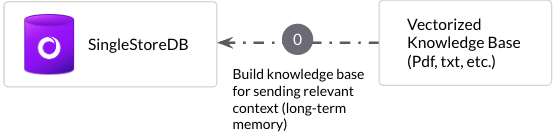

The size of each passage is limited by the embedding model's context window (which is 256 tokens for `all-MiniLM-L6-v2`).

### Load knowledge base documents

Load set of documents used further to build knowledge base. 

In [26]:
from langchain.document_loaders import S3FileLoader
loader = S3FileLoader("studiotutorials", "IBM_Dataset/psgs.tsv",boto_config = botocore.client.Config(signature_version=botocore.UNSIGNED))
data = loader.load_and_split()

In [33]:
# Download the document and Q&A set

s3 = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))
s3.download_file("studiotutorials", "IBM_Dataset/psgs.tsv", "psgs.tsv")
s3.download_file("studiotutorials", "IBM_Dataset/questions_test.csv", "questions_test.csv")


In [27]:
data[0]

Document(page_content="id\ntext\ntitle\n\n\n1\nHistory of Idaho - wikipedia History of Idaho The history of Idaho is an examination of the human history and social activity within the state of Idaho , one of the United States of America located in the Pacific Northwest area near the west coast of the United States and Canada . Other associated areas include southern Alaska , all of British Columbia , Washington , Oregon , western Montana and northern California and Nevada . Contents ( hide ) 1 Indigenous inhabitants 2 European exploration 3 Settlement 3.1 Mormon settlers 3.2 English 3.3 German 3.4 Irish 3.5 African 3.6 Basque 3.7 Chinese settlement 4 Idaho Territory 5 Statehood 5.1 Miners ' uprisings 5.2 Mining in Idaho 5.2. 1 Mining Regions 6 Progressive policies 7 1950s to present 7.1 Nuclear fallout from Nevada test site 8 See also 9 References 10 Bibliography 11 External links Indigenous inhabitants ( edit ) Humans may have been present in Idaho for 14,500 years . Excavations in 19

### Set up SingleStoreDB ingest with embeddings

Define the embedding model to be used

In [34]:
from langchain.embeddings import HuggingFaceEmbeddings
MODEL = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

Create and load the embeddings into a new table. *You don't need to predefine that table.*

Note that the creation of embeddings might take 1 hour. You can shorten that creation by using **data[:1000]** or **data[:10]** - it will only take the first 1,000 or 10 embeddings.

In [35]:
docsearch = SingleStoreDB.from_documents(
    data[:10],
    MODEL,
    table_name = "documents_with_vectors",
)

<a id="predict"></a>
## Generate a retrieval-augmented response to a question

### Select questions

Get questions from the previously loaded test dataset.

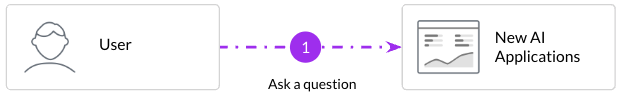

In [36]:
# Setup S3 client without credentials for public access
s3 = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

# Define your bucket and file path
bucket_name = 'studiotutorials'

file_path = 'IBM_Dataset/questions_test.csv'  # replace YOUR_FILENAME with the actual file name

# Fetch the file
obj = s3.get_object(Bucket=bucket_name, Key=file_path)
data = obj['Body'].read().decode('utf-8')

# Read the data into a pandas dataframe
test_data = pd.read_csv(StringIO(data))

In [37]:
test_data.head()

,qid,question,answers
0,6192,when do abby and luka get back together,season 12
1,731,what does dc stand for in washigton dc,District of Columbia
2,7105,most road maps are what kind of map,navigational map
3,6428,who plays captain hook in once upon a time,Colin Arthur O'Donoghue
4,7991,who holds the 3 point record in nba,Ray Allen


The correct answer for "when do abby and luka get back together" is **season 12**

### Retrieve relevant context

Fetch paragraphs similar to the question. This search finds the top 5 closest chunk of texts for every questions to give give context to the QA LLM model.

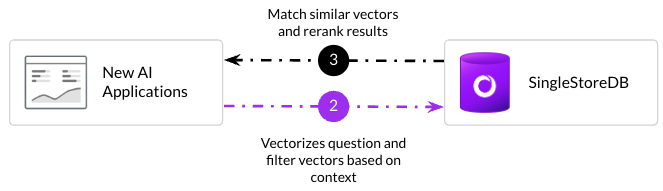

In [39]:
query_text = "when did how to train a dragon come out?"
docs = docsearch.similarity_search(query_text)
print(docs[0].page_content)

3
of the Columbia was created in June 1816 , and Donald Mackenzie was assigned as its head . Mackenzie had previously been employed by Hudson 's Bay and had been a partner in the Pacific Fur Company , financed principally by John Jacob Astor . During these early years , he traveled west with a Pacific Fur Company 's party and was involved in the initial exploration of the Salmon River and Clearwater River . The company proceeded down the lower Snake River and Columbia River by canoe , and were the first of the Overland Astorians to reach Fort Astoria , on January 18 , 1812 . Under Mackenzie , the North West Company was a dominant force in the fur trade in the Snake River country . Out of Fort George in Astoria , Mackenzie led fur brigades up the Snake River in 1816 - 1817 and up the lower Snake in 1817 - 1818 . Fort Nez Perce , established in July , 1818 , became the staging point for Mackenzies ' Snake brigades . The expedition of 1818 - 1819 explored the Blue Mountains , and traveled

### Feed the context and the questions to `watsonx.ai` model and Generate a retrieval-augmented response. Let's compare with and without context response accuracy.

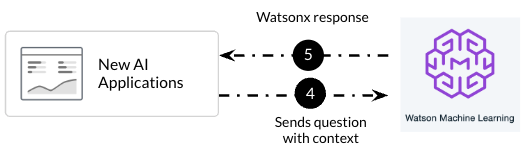

In [40]:
from langchain.chains import RetrievalQA
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

SingleStreDB will give the top 2 most similar answer as context to Watson ML

In [54]:
qa = RetrievalQA.from_chain_type(llm=llm_model, chain_type="stuff", retriever=docsearch.as_retriever(search_kwargs={'k': 4}))


In [55]:
query = "when did how to train a dragon come out?"


In [56]:
qa.run(query)

'2010'

What would be the answer if you don't provide any context to the LLM model?

In [57]:
template = """Answer the question based on the context below. If the
question cannot be answered using the information provided answer
with "I don't know".

Question: {query}

Answer: """

In [58]:
prompt = PromptTemplate(input_variables=["query"],template=template)
llm_chain = LLMChain(prompt=prompt, llm=llm_model)

In [59]:
query = "when did how to train a dragon come out?"

llm_chain.run(query)

'2010'

SingleStoreDB will give the top 2 most similar answer as context to Watson ML

In [60]:
qa1 = RetrievalQA.from_chain_type(llm=llm_model, chain_type="stuff", retriever=docsearch.as_retriever(search_kwargs={'k': 4}))
query1 = "who won the 2015 great british baking show?"
qa1.run(query1)

'Joanne Wheatley'

What would be the answer if you don't provide any context to the LLM model?

In [61]:
template1 = """Answer the question based on the context below. If the
question cannot be answered using the information provided answer
with "I don't know".

Question: {query1}

Answer: """

In [62]:
prompt1 = PromptTemplate(input_variables=["query1"],template=template1)
llm_chain = LLMChain(prompt=prompt1, llm=llm_model)

In [63]:
query1 = "who won the 2015 great british baking show?"

llm_chain.run(query1)

'Joanne Wheatley'

<div class="alert alert-block alert-success">
    <b class="fa fa-solid fa-check-circle"></b>
    <div>
        <p><b>Success</b></p>
        <p>You are done with the demo and you can see how using a contextual database will make your RAG more accurate</p>
    </div>
</div>

Copyright © 2023 IBM. This notebook and its source code are released under the terms of the MIT License.